# SAT Solving for Pairwise Methods

In this notebook, we use a SAT solver to prove Proposition B.3 from the paper [Impossibility theorems involving weakenings of expansion consistency and resoluteness in voting 
](https://arxiv.org/abs/2208.06907) by Wesley H. Holliday, Eric Pacuit, and Saam Zahedian.

## Notebook Overview

1. **SAT Encoding**
    1. SAT setup
    2. Functionality
3. **Weighted tournament embeddings**
    1. Weighted tournament embedding example
    2. Generate canonical weighted tournament embeddings
4. **Binary $\gamma$**
5. **Demonstration of Proposition B.3**
6. **Minimal set of weighted tournaments to prove Proposition B.3**

In [1]:
from itertools import product, combinations, permutations
import pickle
import networkx as nx # for graphs
import matplotlib.pyplot as plt
from pysat.solvers import Glucose3 # SAT solver
from copy import deepcopy
from scipy.special import comb
from tqdm.notebook import tqdm

In [2]:
# helper function

def display_wt(wt, edge_attr):
    """Display a weighted tournament with edge weights"""
    pos = nx.circular_layout(wt)
    nx.draw(wt, pos, font_size=20, node_color='blue', font_color='white',
            node_size=700, width=1, with_labels=True)
    
    edge_labels = nx.get_edge_attributes(wt, edge_attr)
    nx.draw_networkx_edge_labels(wt, pos, edge_labels=edge_labels, label_pos=0.3)
    plt.show()


In [3]:
# Paths to pickled weak tournaments
canonical_weighted_tournament_paths = {
    2: 'weighted_tourns/weighted_tourns_2.pkl',
    3: 'weighted_tourns/weighted_tourns_3.pkl',
    4: 'weighted_tourns/weighted_tourns_4.pkl',
}

# Load all the canonical weighted tournaments
canonical_weighted_tournaments = {nc: pickle.load(open(canonical_weighted_tournament_paths[nc], 'rb'))
                                  for nc in range(2,5)}


## 1. SAT Encoding

### A. SAT setup

We use the [PySAT](https://pysathq.github.io/) toolkit to interface with a SAT solver. Formulas in PySAT are written in conjunctive normal form. Disjunctions are written as lists of integers. A positive integer denotes a propositional variable, a negative integer its negation.

We restrict attention to uniquely weighted canonical weighted tournaments.  Rather than stating quasi-resoluteness as an axiom, we build quasi-resoluteness into our encoding: For a canonical weighted tournament $T$ and a candidate $a$ let $A_{T,a}$ be a propositional variable, where
$A_{T,a}$ means that $a$ is the winner associated with $T$ and  $\neg A_{T,a}$ means that $a$ is not the winner associated with $T$.

In [4]:
def find_possible_winners(min_num_cands, max_num_cands, canonical_graphs): 
    """
    takes dictionary of canonical graphs and range of graph sizes to consider
    for each canonical graph, creates tuples containing the graph and a winner
    """
    possible_winners = {nc: list() for nc in range(min_num_cands, max_num_cands + 1)}
    for nc in possible_winners.keys():
        for g in canonical_graphs[nc]:
            candidates = g.nodes

            for c in candidates: 
                possible_winners[nc].append((g, c))
    return possible_winners

In [5]:
def generate_wt_dictionary(possible_winners):
    """
    takes a dictionary of (weak) tournaments and returns a dictionary (t, ws) -> int
    t is a tournament in 'possible_winners' and ws is a winning set on t satisfying the orbit condition
    """
    wt_dictionary = {}
    wt_id = 1
    for nc in possible_winners.keys(): 
        for wt, w in possible_winners[nc]:
            wt_dictionary.update({(wt, w): wt_id})
            wt_id += 1
    return wt_dictionary

### B. Functionality

The first step is to write a list of clauses for the formula $\mathsf{func}$ in Section B.2. The formula says that for each weighted weak tournament $T$, some candidate wins that is associated with $T$, and it is not the case that two winners are associated with $T$.

For instance, suppose that $T$ is a weighted tournament and there are three possible winning sets for $T$,  $a_1$, $a_2$ and $a_3$. We add the following conjuncts to the formula: 

1. $A_{T,a_1}\vee A_{T,a_2}\vee A_{T,a_3}$
2. $\neg A_{T,a_1}\vee \neg A_{T,a_2}$
3. $\neg A_{T,a_1}\vee \neg A_{T,a_3}$
4. $\neg A_{T,a_2}\vee \neg A_{T,a_3}$.

The conjunction of these formulas says that exactly one of formulas $A_{T,a_1}$, $A_{T, a_2}$ or $A_{T, a_3}$ is true: 

$$(A_{T,a_1}\vee A_{T,a_2}\vee A_{T,a_3}) \wedge (\neg A_{T,a_1}\vee \neg A_{T,a_2})\wedge (\neg A_{T,a_1}\vee \neg A_{T,a_3})\wedge (\neg A_{T,a_2}\vee \neg A_{T,a_3}).$$

Then the above formula means that exactly one of $a_1$, $a_2$ or $a_3$ is the winner associated with $T$. 

In [6]:
def generate_function_formula(graphs, wt_dictionary): 
    """
    takes a list of all graphs 'graphs' and a dictionary of possible winners on those graphs 'wwt_dictionary'
    returns CNF clauses ensuring that only one winning set will be chosen per graph
    """
    C_func = list()
    for g in graphs:     
        # get the list of all atomic formulas describing a possible winning set
        poss_ws = [wt_dictionary[(_g, w)] for _g, w in wt_dictionary.keys() if _g == g]
        # NOTE: we use equality rather than testing for graph isomporphism.  This makes sense since
        # graphs is the set of the networkx objects representing the canonical tournaments and 
        # the keys of wwt_dictionary are tuples where the first components is an object from this lest. 
        C_func.append(poss_ws) # one of the possible winning sets is the winner
        for pairs in combinations(poss_ws, 2):
            # add a clause saying that it is not the case that two possible winning sets are associated 
            # with a weighted tournament
            C_func.append([0 - pairs[0], 0 - pairs[1]])

    return C_func

In [7]:
# Sanity check: This should output True since it is always possible 
# to find some weighted tournament solution on a domain of weighted tournaments

min_num_cands, max_num_cands = 2, 4

canonical_graphs = canonical_weighted_tournaments
graphs = [wt for nc in range(min_num_cands, max_num_cands + 1)  for wt in canonical_graphs[nc]]

possible_winners = find_possible_winners(min_num_cands, max_num_cands, canonical_graphs)
print("Done finding the possible winners.")

wt_dictionary = generate_wt_dictionary(possible_winners)
print("Done creating the encoding.")

C_func = generate_function_formula(graphs, wt_dictionary)
print("Done creating the function formula.\n\n")

sat_solver = Glucose3()
for cl in C_func:
    sat_solver.add_clause(cl)
print(f"Should be true expressing that there is a weighted tournament solution on the domain: {sat_solver.solve()}\n")

# uncomment to see the model (list of literals that are true)
#print(sat_solver.get_model())

Done finding the possible winners.
Done creating the encoding.
Done creating the function formula.


Should be true expressing that there is a weighted tournament solution on the domain: True



## 2. Weighted tournament embeddings


Note that we use "embedding" as it is used in model theory, which is equivalent to being isomorphic to a substructure (see W. Hodges, "Model Theory", pp. 5-6). A canonical weighted tournament $T'$ is a substructure of the canonical weighted tournament $T$ when the set of candidates of $T'$ is a subset of the set of candidates of $T$ and for any candidates $x, y$ in $T'$, there is an edge from $x$ to $y$ in $T'$ with weight $n$ if and only if there is an edge from $x$ to $y$ with weight $n$ in $T$.

[Networkx](https://networkx.org/documentation/stable/reference/algorithms/isomorphism.vf2.html#digraph-matcher) has an algorithm to find isomorphisms from *subgraphs* of $T$ to a graph $T'$.  However, what networkx means by a "subgraph" is not the same as a substructure.   A canonical weak tournament $T'$ is a *subgraph* of $T$ when the set of candidates of $T'$ is a subset of the set of candidates of $T$ and  for any candidates $x, y$ in $T'$, if there is an edge from $x$ to $y$ in $T'$, then there is an edge from $x$ to $y$ in $T$. 

If $T'$ is a (weighted) tournament, then $T'$ is a subgraph of $T$ iff $T'$ is a substructure of $T$. However, since the following code may be run on *weak* (weighted) tournaments, we include the following function to verify that an isomorphism from a subgraph is indeed an embedding. 

In [8]:
def is_embedding(small_g, big_g, iso):
    """
    iso is an isomorphism from small_g to a subgraph of big_g,
    but we must check whether iso is an embedding. 
    returns True if iso is an embedding of small_g into big_g. 
    
    Returns True if for every pair of candidates c1 and c2 in small_g, 
    if there is an edge between iso[c1] and iso[c2] in big_g, then 
    there is an edge between c1 and c2 in small_g
    """
    for c1, c2 in product(small_g.nodes, small_g.nodes): 
        if big_g.has_edge(iso[c1],iso[c2]) and not small_g.has_edge(c1,c2):
            return False
    return True    

A verified _tournament_ embedding is not necessarily a _weighted tournament_ embedding. The function below checks whether a verified tournament embedding also preserves edge weights and is thus a weighted tournament embedding.

In [9]:
# helper function that transforms edges under an isomorphism
edge_conv = lambda e, iso: (iso[e[0]], iso[e[1]])

def preserves_weights(small_g, big_g, iso, edge_attr, verbose=False):
    """
    takes weighted tournament small_g, big_g and an embedding iso from small_g to big_g
    returns true if iso preserves weights from small_g to big_g
    """
    for e in small_g.edges:
        if small_g.edges[e][edge_attr] != big_g.edges[edge_conv(e, iso)][edge_attr]:
            if verbose:
                print("The edge {} in the small graph embeds into the edge {} in the big graph, but the weight of {} in the small graph doesn't match the weight of {} in the big graph.".format(e, edge_conv(e, iso), e, edge_conv(e, iso)))
            return False
    return True

### A. Weighted tournament embedding example

Run the  following code to illustrate the definition of a weighted tournament embedding and why a tournament embeddings is not necessarily a weighted tournament embedding.  

T1: a canonical weighted tournament for 4 candidates: 


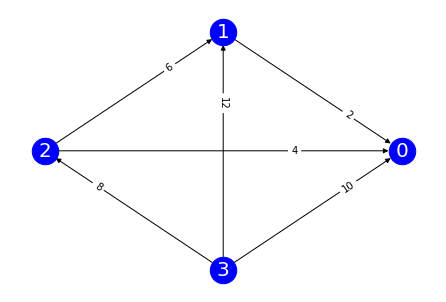

T2: a canonical weighted tournament for 3 candidates: 


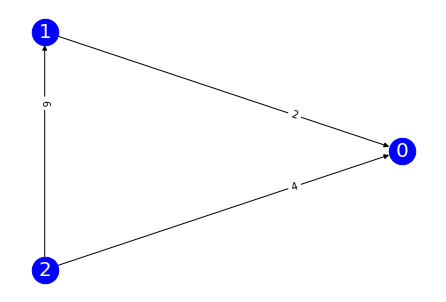

All the tournament embeddings between the weighted tournament T2 with 3 candidates and subgraphs of the weighted tournament T1 with 4 candidates:

e(0) = 0, e(1) = 1, e(2) = 2
	This tournament embedding is also a weighted tournament embedding.


e(0) = 0, e(1) = 1, e(2) = 3
The edge (2, 0) in the small graph embeds into the edge (3, 0) in the big graph, but the weight of (2, 0) in the small graph doesn't match the weight of (3, 0) in the big graph.
	So this tournament embedding is not a weighted tournament embedding.


e(0) = 0, e(1) = 2, e(2) = 3
The edge (1, 0) in the small graph embeds into the edge (2, 0) in the big graph, but the weight of (1, 0) in the small graph doesn't match the weight of (2, 0) in the big graph.
	So this tournament embedding is not a weighted tournament embedding.


e(0) = 1, e(1) = 2, e(2) = 3
The edge (1, 0) in the small graph embeds into the edge (2, 1) in the big graph, but the weight of (1, 0) in the small graph doesn't match the weight of (2, 1) in the 

In [10]:
# name of networkx edge attribute storing each edge's weight
edge_attr = 'weight'

T1 = canonical_weighted_tournaments[4][3]

print("T1: a canonical weighted tournament for 4 candidates: ")
display_wt(T1, edge_attr)

print("T2: a canonical weighted tournament for 3 candidates: ")
T2 = canonical_weighted_tournaments[3][0]
display_wt(T2, edge_attr)

print("All the tournament embeddings between the weighted tournament T2 with 3 candidates and subgraphs of the weighted tournament T1 with 4 candidates:\n")
for iso in nx.algorithms.isomorphism.GraphMatcher(T1, T2).subgraph_isomorphisms_iter():
    # iso is a dictionary mapping a subset of elements of the bigger graph T1 to the 
    # small graph T2, but it is easier to think about the inverse function mapping 
    # nodes in the small graph T2 into the bigger graph T1. 
    inverse_iso = {v:k for k,v in iso.items()}
    
    if not is_embedding(T2, T1, inverse_iso):
        continue
    
    print(", ".join([f"e({c1}) = {c2}" for c1, c2 in inverse_iso.items()]))
    
    if preserves_weights(T2, T1, inverse_iso, edge_attr, verbose=True):
        print("\tThis tournament embedding is also a weighted tournament embedding.\n\n")
    else:
        print("\tSo this tournament embedding is not a weighted tournament embedding.\n\n")

### B. Generate weighted tournament embeddings

Find all weighted tournament embeddings between canonical weighted tournaments of size $n$ and canonical weighted tournaments of size $n+1$. 

In [11]:
def edge_compare_helper(dict1, dict2, edge_attr):
    return dict1[edge_attr] == dict2[edge_attr]

edge_compare = (lambda edge_attr: lambda dict1, dict2: edge_compare_helper(dict1, dict2, edge_attr))(edge_attr)

def find_embeddings(min_num_cands, max_num_cands, canonical_graphs, edge_attr):
    """
    find embeddings of graphs in 'canonical_graphs',
    embeddings of n-tournaments to (n+1)-tournaments, for n=min_num_cands,...,max_num_cands-1
    """
    embeddings = list()

    for nc in range(min_num_cands, max_num_cands): 
        # for each number of candidate between min_num_cands and max_num_cands - 1  

        for g1 in canonical_graphs[nc]: 
            # for each canonical graph of size nc    

            for g2 in canonical_graphs[nc+1]:
                # for each canonical graph of size nc+1

                seen_ranges = set()

                for iso in nx.algorithms.isomorphism.GraphMatcher(g2, g1, edge_match=edge_compare).subgraph_isomorphisms_iter():
                    # for each isomporphism from g1 to a subgraph of g2

                    # NOTE: iso is a dictionary associating a subset of nodes from g2 to the nodes in g1
                    # It's easier to think about the isomorphism as a mapping from the smaller graph g1 
                    # into the bigger graph g2:
                    inverse_iso = {v:k for k,v in iso.items()}

                    rng = tuple(sorted(iso.keys())) # the range of the isomorphism (nodes in the bigger graph)
                    if not rng in seen_ranges and is_embedding(g1, g2, inverse_iso) and \
                    preserves_weights(g1, g2, inverse_iso, edge_attr):
                        # if haven't seen the range yet, g1 is an embedding into g2, 
                        # and the embedding preserves edge weights
                        seen_ranges.add(rng)
                        # record the smaller graph g1, larger graph g2 and isomorphism from g1 to g2
                        embeddings.append((g1, g2, inverse_iso))  
    return embeddings

## 3. Binary $\gamma$

In [12]:
def generate_bg_formula(min_num_cands, 
                        max_num_cands, 
                        canonical_graphs, 
                        wt_dictionary, 
                        embeddings,
                        edge_attr): 
    """
    returns CNF clauses expressing binary gamma
    """
    C_bg = list()
    
    can_2_tourn_dict = {[e[2]['weight'] for e in wt.edges(data=True)][0]: wt  
                        for wt in canonical_graphs[2]}

    can_2_tourn_maj_pref_cand = [c for c in can_2_tourn_dict[2].nodes 
                                 if can_2_tourn_dict[2].out_degree(c) == 1][0]
    
    can_2_tourn_min_pref_cand = [c for c in can_2_tourn_dict[2].nodes 
                                 if c != can_2_tourn_maj_pref_cand][0]


    for nc in range(min_num_cands, max_num_cands + 1):

        for t1 in canonical_graphs[nc]:
            # for each canonical weighted tournament for nc candidates
            
            for emb in [_emb for _emb in embeddings if _emb[0] == t1]: 
                # for each possible embedding from t1 into a canonical majority graph emb[1]
                
                t2 = emb[1]
                # t2 is a canonical weighted tournament for nc+1 candidates, which t1 embeds into
                
                new_cand = list(set(emb[1].nodes).difference(set(emb[2].values())))[0]
                # new_cand is the candidate in t2 not in the range of the embedding from t1 to t2
                
                for cand in t1.nodes:
                    cand_t2 = emb[2][cand]
                    if (cand_t2, new_cand) in t2.edges: # if cand_t2 is majority preferred to new_cand
                        
                        # if cand is a winner in t2
                        clause = [-wt_dictionary[(t1, cand)]]
                        
                        # if cand_ts is majority preferred to new_cand by the right margin
                        can_2_tourn = can_2_tourn_dict[t2.edges[(cand_t2, new_cand)][edge_attr]]
                        clause += [-wt_dictionary[(can_2_tourn, can_2_tourn_maj_pref_cand)]]    
                        
                        # then cand_t2 must be the winner in t2
                        clause += [wt_dictionary[(t2, cand_t2)]]                       
                        
                        C_bg.append(clause)
                            
                    elif (new_cand, cand_t2) in t2.edges: # if cand_t2 is minority preferred to new_cand
                        
                        # if cand is a winner in t2
                        clause = [-wt_dictionary[(t1, cand)]]

                        # if minority rule on two-candidate tournament with same weight as cand_t2 <- new_cand
                        can_2_tourn = can_2_tourn_dict[t2.edges[(new_cand, cand_t2)][edge_attr]]
                        clause += [-wt_dictionary[(can_2_tourn, can_2_tourn_min_pref_cand)]]
                        
                        # then cand_t2 must be the winner in t2
                        clause += [wt_dictionary[(t2, cand_t2)]]                       
                        
                        C_bg.append(clause)
                            
                    else:
                        raise Exception
                        
    return C_bg


## 4. Demonstration of Proposition B.3

In [13]:
min_num_cands,max_num_cands = 2, 4

canonical_graphs = canonical_weighted_tournaments

graphs = [mg for nc in range(min_num_cands, max_num_cands + 1) for mg in  canonical_graphs[nc]]

possible_winners = find_possible_winners(min_num_cands, max_num_cands, canonical_graphs)
print("Done finding the possible winners.")

wt_dictionary = generate_wt_dictionary(possible_winners)
print("Done creating the encoding.")

C_func = generate_function_formula(graphs, wt_dictionary)
print("Done creating the function formula.")


Done finding the possible winners.
Done creating the encoding.
Done creating the function formula.


In [14]:

embeddings = find_embeddings(min_num_cands, max_num_cands, canonical_graphs, edge_attr)
print("Done creating the embeddings.")

C_bg = generate_bg_formula(min_num_cands, 
                           max_num_cands, 
                           canonical_graphs, 
                           wt_dictionary, 
                           embeddings,
                           edge_attr)

print("Done creating the BG clauses")

Done creating the embeddings.
Done creating the BG clauses


In [15]:
formula = C_func + C_bg

sat_solver = Glucose3()
for cl in formula:
    sat_solver.add_clause(cl)

if sat_solver.solve(): 
    print(f"There is a canonical weighted tournament solution up to {max_num_cands} candidates that satisfies the orbit condition, QR and BG.")
else: 
    print(f"There is no canonical weighted tournament solution up to {max_num_cands} candidates that satisfies the orbit condition, QR and BG.")
# uncomment to see the modle (list of literals that are true)
#print(sat_solver.get_model())
vm = sat_solver.get_model()

There is no canonical weighted tournament solution up to 4 candidates that satisfies the orbit condition, QR and BG.


## 5. Minimal set of weighted tournaments to prove Proposition B.3

It turns out that not all of the canonical weighted tournaments used above are needed for the unsatisfiability result.   Below, we load two minimal sets of canonical tournaments that suffice for the unsatisfiability.   By *minimal* we mean that removing any tournament from the set results in a satisfiability result.  

### First minimal set of weighted tournaments

First, we import a minimal set obtained the "naive approach" described in Appendix B.4

In [16]:
wts_for_impossibility = pickle.load(open("./graphs_for_impossibilities/wts_for_impossibility.pkl", "rb"))

In [17]:
min_set_canonical_weighted_tournaments = dict()
min_set_canonical_weighted_tournaments[2] = canonical_weighted_tournaments[2]
min_set_canonical_weighted_tournaments[3] = [wt for wt in wts_for_impossibility if len(wt.nodes) == 3]
min_set_canonical_weighted_tournaments[4] = [wt for wt in wts_for_impossibility if len(wt.nodes) == 4]

for nc in min_set_canonical_weighted_tournaments.keys(): 
    print(f"There are {len(min_set_canonical_weighted_tournaments[nc])} weighted tournaments with {nc} candidates.")

There are 6 weighted tournaments with 2 candidates.
There are 140 weighted tournaments with 3 candidates.
There are 570 weighted tournaments with 4 candidates.


In [18]:
min_num_cands,max_num_cands = 2, 4

canonical_graphs = min_set_canonical_weighted_tournaments

graphs = [mg for nc in range(min_num_cands, max_num_cands + 1) for mg in canonical_graphs[nc]]

possible_winners = find_possible_winners(min_num_cands, max_num_cands, canonical_graphs)
print("Done finding the possible winners.")

wt_dictionary = generate_wt_dictionary(possible_winners)
print("Done creating the encoding.")

C_func = generate_function_formula(graphs, wt_dictionary)
print("Done creating the function formula.")

embeddings = find_embeddings(min_num_cands, max_num_cands, canonical_graphs, edge_attr)
print("Done creating the embeddings.")

C_bg = generate_bg_formula(min_num_cands, 
                           max_num_cands, 
                           canonical_graphs, 
                           wt_dictionary, 
                           embeddings,
                           edge_attr)
print("Done creating the BG clauses")

Done finding the possible winners.
Done creating the encoding.
Done creating the function formula.
Done creating the embeddings.
Done creating the BG clauses


In [19]:
formula = C_func + C_bg

sat_solver = Glucose3()
for cl in formula:
    sat_solver.add_clause(cl)

if sat_solver.solve(): 
    print(f"There is a canonical weighted tournament solution up to {max_num_cands} candidates that satisfies the orbit condition, QR and BG.")
else: 
    print(f"There is no canonical weighted tournament solution up to {max_num_cands} candidates that satisfies the orbit condition, QR and BG.")
# uncomment to see the modle (list of literals that are true)
#print(sat_solver.get_model())
vm = sat_solver.get_model()

There is no canonical weighted tournament solution up to 4 candidates that satisfies the orbit condition, QR and BG.


### Second minimal set of weighted tournaments

Next, we import a minimal set of weighted tournaments extracted from the MUS provided by PicoMUS as described in Appendix B.4

In [21]:
all_gs_mus_dict = pickle.load(open("./graphs_for_impossibilities/all_gs_mus_dict_pairwise.pkl", "rb"))

In [22]:
for nc in all_gs_mus_dict.keys():
    print(f"There are {len(all_gs_mus_dict[nc])} weighted tournaments with {nc} candidates.")
    

There are 6 weighted tournaments with 2 candidates.
There are 160 weighted tournaments with 3 candidates.
There are 1484 weighted tournaments with 4 candidates.


In [23]:
min_num_cands,max_num_cands = 2, 4

canonical_graphs = min_set_canonical_weighted_tournaments

graphs = [mg for nc in range(min_num_cands, max_num_cands + 1) for mg in canonical_graphs[nc]]

possible_winners = find_possible_winners(min_num_cands, max_num_cands, canonical_graphs)
print("Done finding the possible winners.")

wt_dictionary = generate_wt_dictionary(possible_winners)
print("Done creating the encoding.")

C_func = generate_function_formula(graphs, wt_dictionary)
print("Done creating the function formula.")

embeddings = find_embeddings(min_num_cands, max_num_cands, canonical_graphs, edge_attr)
print("Done creating the embeddings.")

Done finding the possible winners.
Done creating the encoding.
Done creating the function formula.
Done creating the embeddings.


In [24]:
C_bg = generate_bg_formula(min_num_cands, 
                           max_num_cands, 
                           canonical_graphs, 
                           wt_dictionary, 
                           embeddings,
                           edge_attr)
print("Done creating the BG clauses")

Done creating the BG clauses


In [25]:
formula = C_func + C_bg

sat_solver = Glucose3()
for cl in formula:
    sat_solver.add_clause(cl)

if sat_solver.solve(): 
    print(f"There is a canonical weighted tournament solution up to {max_num_cands} candidates that satisfies the orbit condition, QR and BG.")
else: 
    print(f"There is no canonical weighted tournament solution up to {max_num_cands} candidates that satisfies the orbit condition, QR and BG.")
# uncomment to see the modle (list of literals that are true)
#print(sat_solver.get_model())




There is no canonical weighted tournament solution up to 4 candidates that satisfies the orbit condition, QR and BG.
